In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from scipy.stats import gamma, multivariate_normal

from gproc.elliptic import ess_samples_probit
from gproc.generative import sample_at_x
from gproc.kernels import *
from gproc.laplace import laplace_approximation_probit
from gproc.approx_marginal_is import importance_sampler
from gproc.metropolis_hastings import *

In [2]:
N = 50 # Data size
D = 1 # Data dimension

x = np.random.normal(0, 1, N * D).reshape(-1, D) # Reshape to N x D matrix
true_lengthscale = 1
true_variance = 1
y, prob_y, f = sample_at_x(x, kernel_fcn = squared_exponential, kernel_params = {'lengthscale': true_lengthscale, 'variance': true_variance})

lap_kernel = SquaredExponential(lengthscale = true_lengthscale, variance = true_variance)

gram = lap_kernel.make_gram(x, x)
inverse_gram = chol_inverse(gram)

In [3]:
# Get approximation to latent function posterior
laplace_mean, df_ll, laplace_cov, objective_history, converged = laplace_approximation_probit(y, inverse_gram)

print(f'Converged: {converged}')

marg_0 = importance_sampler(y, x, laplace_mean, laplace_cov, 100)
marg_0

Converged: True


-27.39308432663431

In [5]:
Kernel = SquaredExponential

th_0 = np.array([np.log(true_lengthscale), np.log(true_variance)])
th_arr, marg_arr, move_arr, acc_rate_hist, cov_scale_hist, inverse_gram_arr = mh(10000, y, x, Kernel, th_0, marg_0, cov = np.eye(th_0.shape[0]), cov_scale = 0.2, target_acc_rate = 0.25, scale_iters = 25, N_imp = 64, verbose = True)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.44it/s]


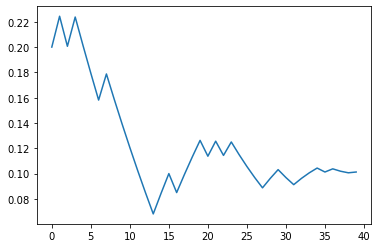

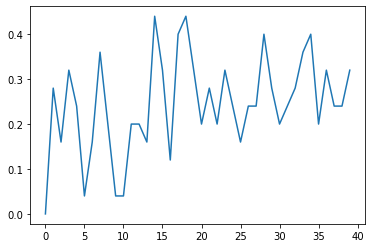

In [6]:
plt.plot(cov_scale_hist)
plt.show()
plt.plot(acc_rate_hist)
plt.show()

Acceptance rate = 25.333333333333336


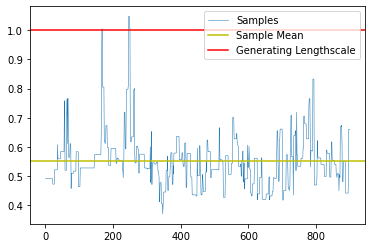

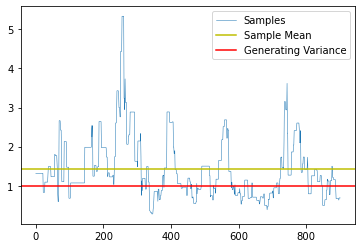

In [7]:
burn_in = 100
print(f'Acceptance rate = {move_arr[burn_in:].mean()*100}')

plt.plot(np.exp(th_arr[burn_in:, 0]), label = 'Samples', linewidth = 0.5)
plt.axhline(y = np.mean(np.exp(th_arr[burn_in:, 0])), c = 'y', label = 'Sample Mean')
plt.axhline(y = true_lengthscale, label = 'Generating Lengthscale', c = 'r')
plt.legend()
plt.show()

plt.plot(np.exp(th_arr[burn_in:, 1]), label = 'Samples', linewidth = 0.5)
plt.axhline(y = np.mean(np.exp(th_arr[burn_in:, 1])), c = 'y', label = 'Sample Mean')
plt.axhline(y = true_variance, label = 'Generating Variance', c = 'r')
plt.legend()
plt.show()
